# Data Preparation

This section explains the limitations of the `with_columns` and `filter` methods in our `dp` plugin for Polars. 

Although these methods function similarly to normal Polars versions, in this context there are privacy implications that may not be immediately apparent. 


## Set Up

In [6]:
import polars as pl 
import opendp.prelude as dp
import seaborn as sns 
import matplotlib.pyplot as plt

dp.enable_features("contrib")
sns.set_theme(style='darkgrid')

In [7]:
!curl 'https://github.com/opendp/dp-test-datasets/blob/master/data/sample_FR_LFS.csv.zip?raw=true' --location --output data.zip
!unzip data.zip
df = pl.scan_csv("sample_FR_LFS.csv", ignore_errors=True)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 5933k  100 5933k    0     0  1088k      0  0:00:05  0:00:05 --:--:-- 1139k
Archive:  data.zip
  inflating: sample_FR_LFS.csv       
  inflating: __MACOSX/._sample_FR_LFS.csv  


In [8]:
estimated_max_partition_len = 60_000_000

context = dp.Context.compositor(
    data=df,
    privacy_unit=dp.unit_of(contributions=36),
    privacy_loss=dp.loss_of(epsilon=1.0),
    split_evenly_over=5,
    margins={
        ("YEAR", ): dp.Margin(max_partition_length=estimated_max_partition_len, max_partition_contributions=4),
        ("ILOSTAT", ): dp.Margin(max_partition_length=estimated_max_partition_len),
        (): dp.Margin(public_info= "lengths",max_partition_length=estimated_max_partition_len, max_num_partitions=1),
    },
)

## Limitations of `with_columns`

The method `with_columns` is used to add or change columns in a data frame. One common use is adding human-readable labels for variables that have numerical coding. For example, the following query computes the number of people in each labor category and then adds the codes' meaning. 

In [9]:
dp_values = context.query().group_by("ILOSTAT").agg(pl.len().dp.noise()).release().collect()

labor_status_codes = {
    9: 'NA',
    2: 'Not Working But Employed',
    1: 'Working for Pay', 
    3: 'Laid Off'
}

dp_values_with_names = dp_values.with_columns(
    pl.col("ILOSTAT").map_elements(lambda x: labor_status_codes.get(x, x))
)

dp_values_with_names

ILOSTAT,len
str,u32
"""Laid Off""",75639
"""NA""",35922
"""Working for Pa…",79844
"""Not Working Bu…",8002


Although the use of `with_columns` is not directly in a DP query, it does have some important implications that help maintain the DP unit of privacy such as: 

### 1. Number of Rows is Unchanged. 

This is crucial because differential privacy ensures the privacy guarantee is based on the key entity's contributions specified in the compositor. Keeping the row count consistent prevents unintentional changes in the key entity's contributions. 

### 2. Ordering of Rows is Unchanged. 

The ordering of the rows is important because it also ensures consistency in the key entity's contribution. If the order was changed, through a sort for instance, then the users' contribution could also change, diminishing the privacy guarantee. 


## Limitations of `filter`

Filtering can be thought of as a type of partition. When filtering results in a smaller subset, it can lead to an increase in noise and a decrease in utility.

Moreover, if you were to filter by a key with public lengths and then group by that key, you effectively introduce two layers of partitioning. These multiple layers of partitioning can significantly diminish the privacy guarantee since the individual partitions are smaller so more noise must be added to each layer to meet the privacy guarantee. When the two layers are combined, the compounded noise further contributes to the decreased utility. 

This is demonstrated by the following example which computes the total count of respondents not working due to a layoff per year. 

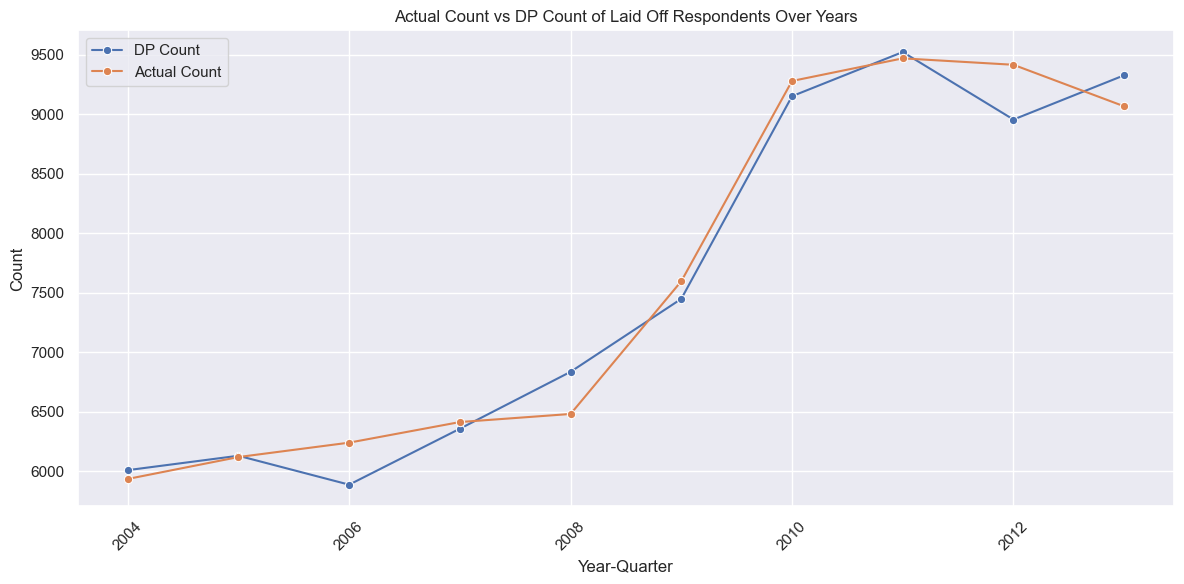

In [10]:
year_dp = (context.query().
           filter(pl.col("ILOSTAT")==3).
           group_by("YEAR").agg(
                                pl.len().dp.noise().alias("DP Count")
                                ).sort("YEAR")
            ).release().collect()

year_actual = (df.
               filter((pl.col("ILOSTAT")==3)).
               group_by("YEAR").
               agg(
                   pl.col("YEAR").
                   count().
                   alias("Actual Count")
                ).sort("YEAR")).collect()

plt.figure(figsize=(12, 6))
sns.lineplot(x=year_dp["YEAR"].to_list(), y=year_dp['DP Count'].to_list(), marker='o', label='DP Count')
sns.lineplot(x=year_actual["YEAR"].to_list(), y=year_actual['Actual Count'].to_list(), marker='o', label='Actual Count')

plt.title('Actual Count vs DP Count of Laid Off Respondents Over Years')
plt.xlabel('Year-Quarter')
plt.ylabel('Count')
plt.xticks(rotation=45) 
plt.legend()

plt.grid(True)
plt.tight_layout()  
plt.show() 

## Conclusion

The methods `with_columns` and `filter` are powerful and common methods in data analysis. Although their usage may be similar in polars and with the OpenDP library, note that these methods have important limitations and implications for maintaining differential privacy. 